# Bank Churn Prediction With Cost Optimization

## Data Cleaning & EDA

In [133]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina') #this option makes plots crisp clear
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from sklearn.metrics import classification_report

In [220]:
df=pd.read_csv('./Churn_Modelling.csv')

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [219]:
df.shape[0]

10000

In [135]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

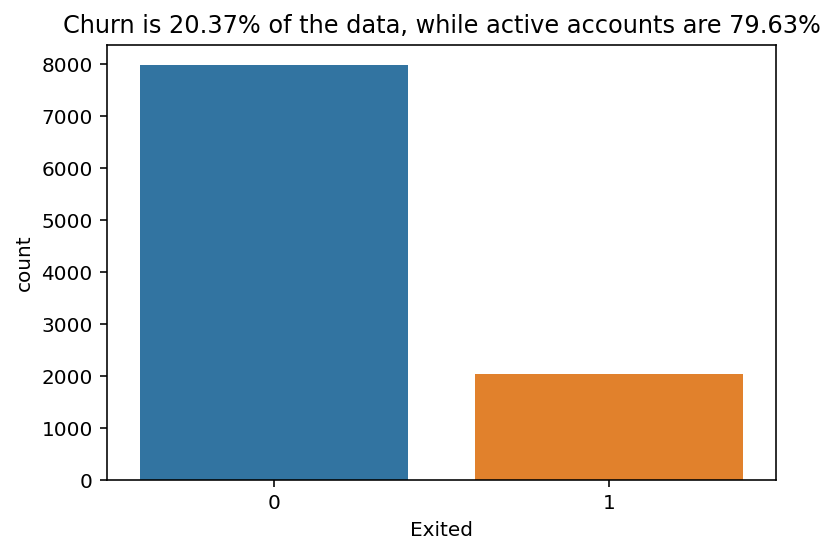

In [136]:

churn_count=round(df['Exited'].value_counts(normalize=True)*100,2)
plt.title('Churn is {}% of the data, while active accounts are {}%'.format(churn_count[1],churn_count[0]))
sns.countplot(df['Exited'])
plt.show();


In [138]:
# Lets check for missig values
np.where((df.isna().any().sum())==0, print('There are no missing values'),\
         df.isna().any().sum())

There are no missing values


array(None, dtype=object)

In [139]:
#lets check mean, std of the data, this helps check variability
df.iloc[:,2:].describe()

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769  
min        0.00000        0.000000        11.580000      0.000000  
25%        0.00000        0.000000     51002.110000      0.000000  
50%        1.00000        1.000000    100193.915000      0.000000  
75%        1.00000        1.000000    149388.247500      0.000000  
max        1.00000        1.000000    199992.480000      1.000000

In [140]:
#columns that have a single value
[col for col in df.iloc[:,1:].columns if df.iloc[:,1:][col].nunique()==1]

[]

In [141]:
df.info() #checking data types for all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [142]:
#check if we have duplicate customers

df['CustomerId'].duplicated().sum() #no duplicates

0

We create a new category that contains country and gender, then encode it with count

In [143]:
#taking care of categorical data

df['country_gender']=df['Geography']+'_'+df['Gender']

#transform categories to their counts in the data
df['country_gender']=df.groupby('country_gender')['CustomerId'].transform('count')
df['Gender']=df.groupby('Gender')['CustomerId'].transform('count')
# df['Geography']=df.groupby('Geography')['CustomerId'].transform('count')
df=df.drop(['Gender','Geography'],1)
df.head()

RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1    15634602  Hargrave          619   42       2       0.00   
1          2    15647311      Hill          608   41       1   83807.86   
2          3    15619304      Onio          502   42       8  159660.80   
3          4    15701354      Boni          699   39       1       0.00   
4          5    15737888  Mitchell          850   43       2  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1        101348.88       1   
1              1          0               1        112542.58       0   
2              3          1               0        113931.57       1   
3              2          0               0         93826.63       0   
4              1          1               1         79084.10       0   

   country_gender  
0            2261  
1            1089  
2            2261  
3            2261  
4            1089

I choose to use MI because it captures non linear relationships 
The scikit-learn algorithm for MI treats discrete features differently from continuous features.
W need to explicitly tell the algorithm which features are discrete, but from the .info output, our data does not have discrete features


In [144]:

X = df.drop(['CustomerId','RowNumber','Surname'],1) #drop id column
y = X.pop("Exited") #take target

# # Label encoding for categoricals
# for colname in X.select_dtypes("object"):
#     X[colname], _ = X[colname].factorize()

# discrete_features = X.dtypes == int

def minf_scores(X, y):
    '''
    INPUT:
    : X - all independent variables
    : y - the target/dependent variable
    : discrete_features - discrete features in X
    
    OUTPUT:
    : columns with their MI scores
    '''
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = round(minf_scores(X, y),2)
pd.set_option('display.max_rows', 500) #we set this to view all rows
mi_scores

NumOfProducts      0.08
Age                0.07
country_gender     0.02
IsActiveMember     0.01
Balance            0.01
CreditScore        0.00
EstimatedSalary    0.00
HasCrCard          0.00
Tenure             0.00
Name: MI Scores, dtype: float64

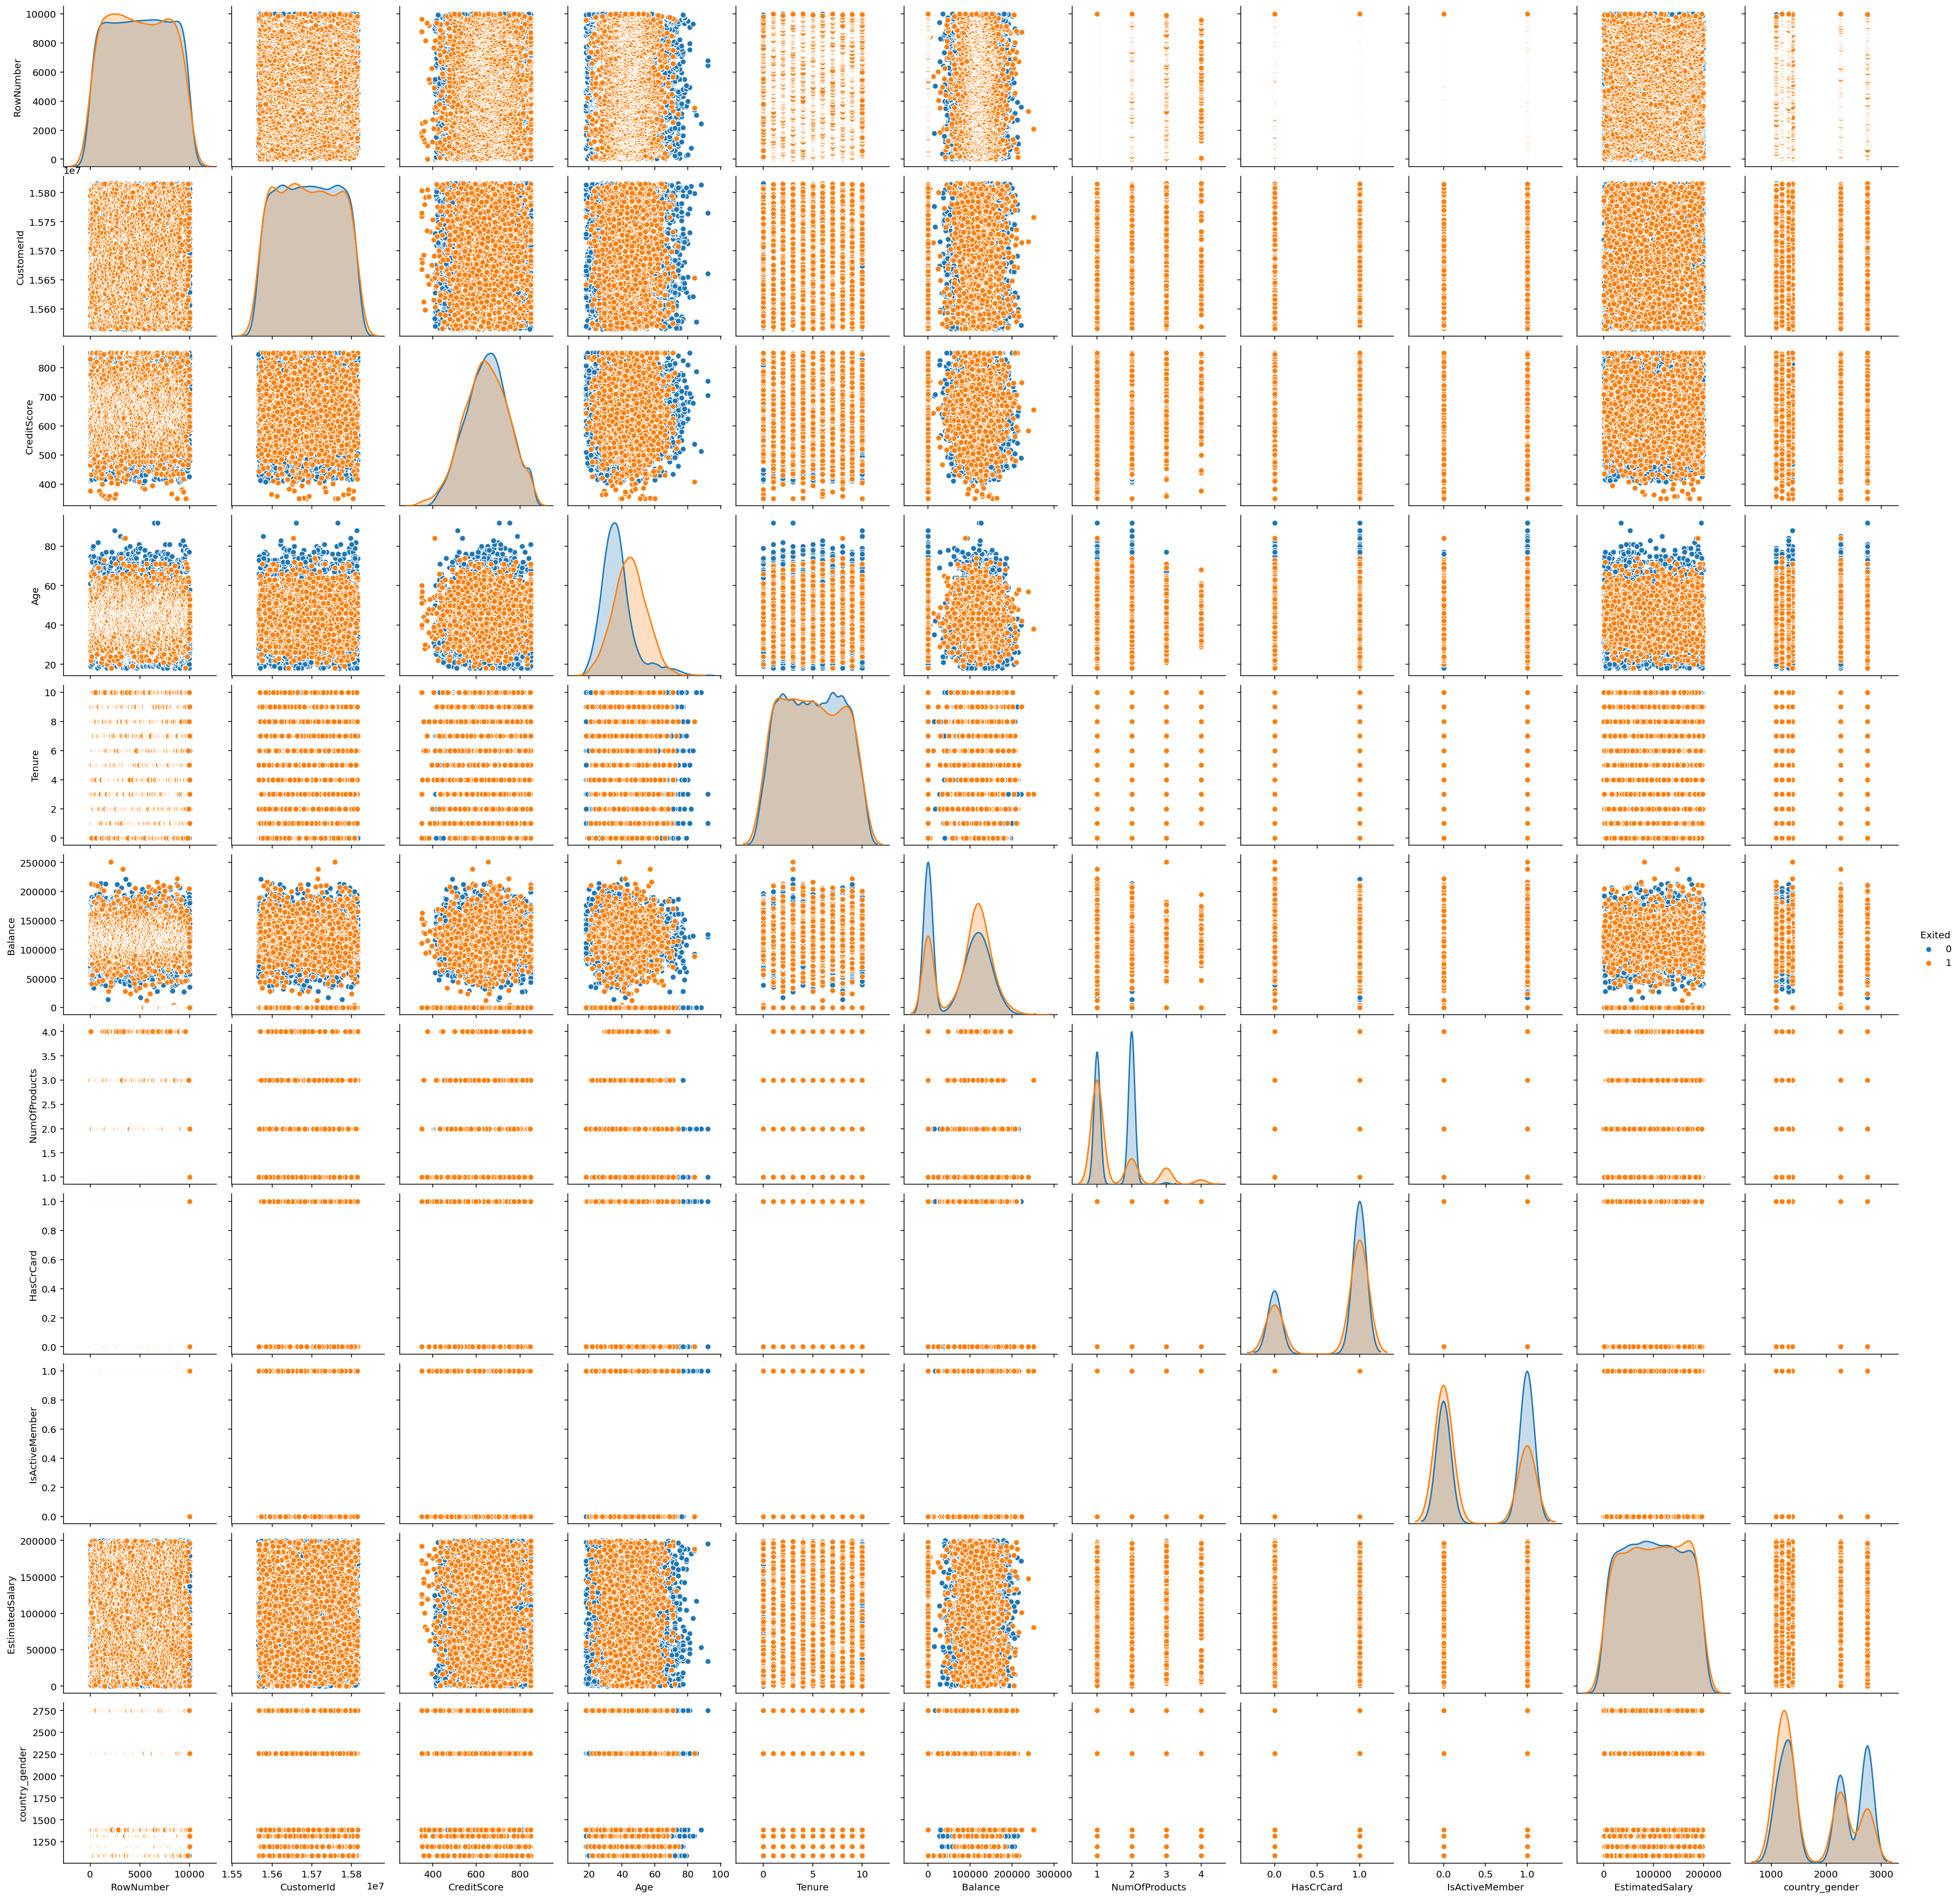

In [145]:
sns.pairplot(df, hue="Exited")
plt.show();

### How Does Age, Number Of Products Used Affect Churn

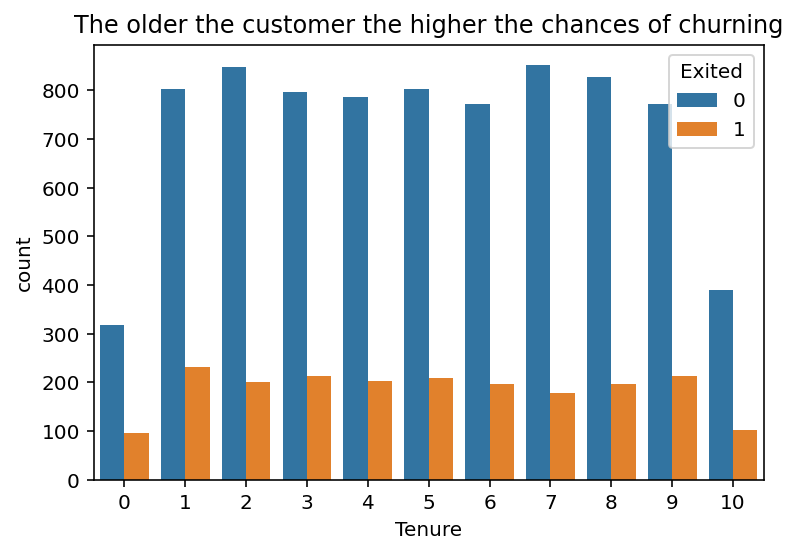

In [147]:
plt.title('The older the customer the higher the chances of churning')

sns.countplot(df['Tenure'],hue=df['Exited'])
plt.show();


distribution for tenure looks the same for churn and active

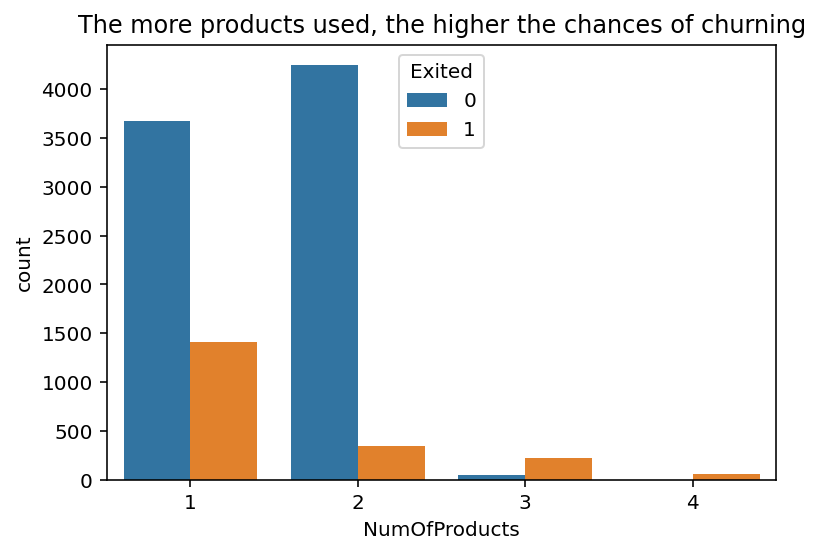

In [193]:
plt.title('The more products used, the higher the chances of churning')
sns.countplot(df['NumOfProducts'],hue=df['Exited'])
plt.show();
#the more the number or products used (>=3), the higher the chances of churning

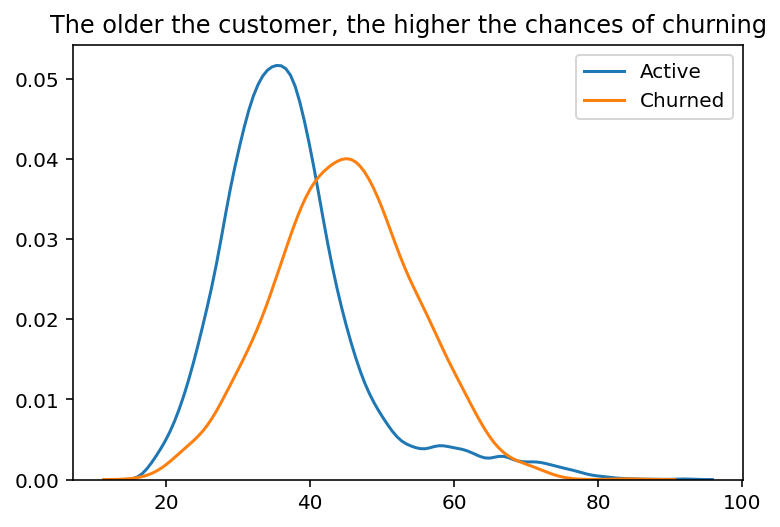

In [211]:
plt.title('The older the customer, the higher the chances of churning')
sns.kdeplot(df[df['Exited']==0]['Age'],label='Active')
sns.kdeplot(df[df['Exited']==1]['Age'],label='Churned')
plt.show();

### Cross validation Strategy

We build a cross validation strategy below:

In [150]:
# we need to take care of cross validation as below
from sklearn import model_selection

if __name__ == "__main__":
    # we create a new column called kfold and fill it with -1
    #we wont have negative folds so we fill with -1 so incase we have issues we can identify them

    df["kfold"] = -1

    # the next step is to randomize the rows of the data df = df.sample(frac=1).reset_index(drop=True)

    # fetch labels y = df.target.values

    # initiate the kfold class from model_selection module

    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column

    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):

        df.loc[v_, 'kfold'] = f
df['kfold'].value_counts() #even random distribution across all 5 folds

0    2000
1    2000
2    2000
3    2000
4    2000
Name: kfold, dtype: int64

In [151]:
#This function runs models on the folds
def run(fold,model,df):


    # get training data using folds 
    df_train = df1[df1.kfold != fold].reset_index(drop=True)
    x_train=df_train.drop('Exited',1)
    # get validation data using folds 
    df_valid = df1[df1.kfold == fold].reset_index(drop=True)
    
    x_valid=df_valid.drop('Exited',1)
    # initialize Logistic Regression model 
    model = model()

    # fit model on training data 
    model.fit(x_train, df_train.Exited.values)

    # predict on validation data # we need the probability values as we are calculating AUC 
    # we will use the probability of 1s 
    valid_preds = model.predict(x_valid)

    # get roc auc score 
#     precision = round(metrics.precision_score(df_valid.Exited.values, valid_preds),2)

   
#     print(f"Fold = {fold}, Precision = {precision}")
    print(classification_report(df_valid.Exited.values,model.predict(x_valid)))





In [152]:
df1=df.drop(['CustomerId','RowNumber','Surname'],1)

#logistic regression
if __name__ == "__main__":

    for fold_ in range(5): #for the 5 folds

        run(fold_,LogisticRegression,df1)

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1592
           1       0.46      0.09      0.15       408

    accuracy                           0.79      2000
   macro avg       0.63      0.53      0.52      2000
weighted avg       0.74      0.79      0.73      2000

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1592
           1       0.37      0.07      0.12       408

    accuracy                           0.79      2000
   macro avg       0.58      0.52      0.50      2000
weighted avg       0.71      0.79      0.72      2000

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1593
           1       0.40      0.08      0.13       407

    accuracy                           0.79      2000
   macro avg       0.60      0.52      0.50      2000
weighted avg       0.72      0.79      0.73      2000

              preci

### Feature Variance Reduction

In [156]:
#lets check columns that have very high variance so we can reduce the same by logging

def col_var(df,col):
    '''
    INPUT
    :df dataframe
    :col column names
    OUTPUT
    :variance per columns in a tuple'''
    print((col,df[col].var()))

if __name__ == "__main__":

    for cols_ in X.columns: #for the 5 folds

        col_var(X,cols_)

('CreditScore', 9341.860156575658)
('Age', 109.99408416841683)
('Tenure', 8.364672627262726)
('Balance', 3893436175.990742)
('NumOfProducts', 0.33832179217921793)
('HasCrCard', 0.20779052905290527)
('IsActiveMember', 0.2497969696969697)
('EstimatedSalary', 3307456784.134512)
('country_gender', 442329.87128712883)


In [157]:
# we see that Balance,and EstimatedSalary have very high variances and are good candidates for log transformation

In [158]:
df['Balance1']=np.log1p(df['Balance']) #we use lo1p incase there is a zero value
df['EstimatedSalary1']=np.log1p(df['EstimatedSalary'])

### Models - Random Forest

After reducing the variance we get better results on ligistic regression, though still very low on recall

Lets try using a tree based model, random forest

In [161]:
#random forest
if __name__ == "__main__":

    for fold_ in range(5): #for the 5 folds

        run(fold_,RandomForestClassifier,df1)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1592
           1       0.78      0.43      0.55       408

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.73      2000
weighted avg       0.85      0.86      0.84      2000

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1592
           1       0.81      0.48      0.60       408

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.87      0.87      0.86      2000

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

              preci

Vanilla rf performs better, but still not good on recall

#### Multiple Optimized Models With Voting

Lets try multiple models approach with voting, as well as grid search for all models

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X = df1.drop('Exited',1)
y= df1['Exited']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
        
knn_params = {'n_neighbors':np.arange(1,50)}

nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

rf_params =  {'max_features':[1,3,10],
              'min_samples_split':[2,3,10],
              'min_samples_leaf':[1,3,10],
              'bootstrap':[False],
              'n_estimators':[100,300],
              'criterion':['gini']}

gb_params = {'learning_rate':[0.001,0.01,0.1,0.05],
            'n_estimators':[100,500,100],
            'max_depth':[3,5,10],
            'min_samples_split':[2,5,10]
    
}

param = [rf_params,knn_params,nb_params,gb_params]

In [32]:
classifier = [RandomForestClassifier(),
              KNeighborsClassifier(),
              GaussianNB(),
              GradientBoostingClassifier()
             ]

ml_list = ['Random Forest','KNN','Naive Bayes','GradientBoosting']

In [33]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score


cv_results = []
best_estimators = []

for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i],
                            param_grid=[param[i]],
                            cv = StratifiedKFold(n_splits=5),
                            scoring = 'roc_auc',
                             n_jobs= -1,
                             verbose = 1
                        
                            )
    clf.fit(X_train,y_train)
    cv_results.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print('Method: {}  Score: {} Best: {}' .format(classifier[i],cv_results[i],clf.best_estimator_))
    
results = pd.DataFrame({'CV Means':cv_results,
                       'ML Models':ml_list})

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 13.5min finished


Method: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)  Score: 0.8562498775141669 Best: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 238 out of 245 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Method: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')  Score: 0.7269274104424198 Best: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=23, p=2,
                     weights='uniform')
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Method: GaussianNB(priors=None, var_smoothing=1e-09)  Score: 0.7925026211968271 Best: GaussianNB(priors=None, var_smoothing=3.5111917342151277e-08)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 71.3min finished


Method: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)  Score: 0.8606648987072806 Best: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity

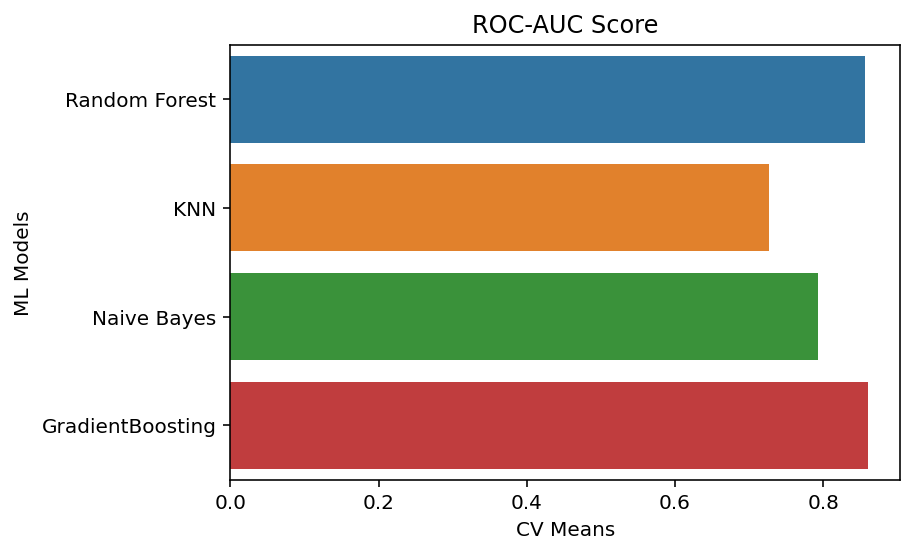

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.barplot('CV Means','ML Models',data=results)
g.set_title('ROC-AUC Score')
plt.show()

In [35]:
from sklearn.ensemble import VotingClassifier
voting_c = VotingClassifier(estimators=[('rf',best_estimators[0]),
                                        ('knn',best_estimators[1]),
                                        ('nb',best_estimators[2]),
                                        ('gb',best_estimators[3])
                                       ],
                           voting='soft',
                           n_jobs=-1)

voting_c = voting_c.fit(X_train,y_train)
print(classification_report(y_test,voting_c.predict(X_test)))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1607
           1       0.81      0.36      0.50       393

    accuracy                           0.86      2000
   macro avg       0.84      0.67      0.71      2000
weighted avg       0.85      0.86      0.84      2000



#### Optimized GBM

The results are still bad for recall, lets concentrate on GBM model with its best parameters which gives a better performance for recall

In [174]:
model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

# fit model on training data 
model.fit(X_train, y_train)


print(classification_report(y_test,model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2416
           1       0.80      0.46      0.59       584

    accuracy                           0.87      3000
   macro avg       0.84      0.72      0.76      3000
weighted avg       0.87      0.87      0.86      3000



## Model Threshold Optimization With Misclassification Costs

If we take into account misclassification penalties interms of costs, can we optimize the model to save money on the win back campaigns?

money saved: $ 43950


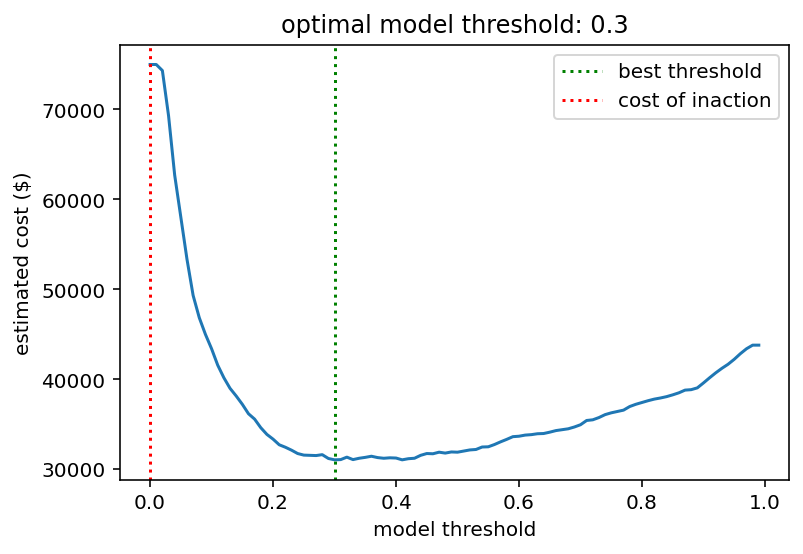

In [222]:
pred_proba = model.predict_proba(X_test)[:, 1]

def get_classifications(true, proba, thresh):
    """
    Gets true positive (tp), false positive (fp),
    true negative (tn), false negative (fn)
    given true values (true), proba (array of probabilities),
    and a probability threshold.
    returns tp, fp, tn, fn
    """
    pred = np.where(proba > thresh, 1, 0)
    tp = np.where((pred == 1)&(true == 1), 1, 0).sum()
    fp = np.where((pred == 1)&(true == 0), 1, 0).sum()
    tn = np.where((pred == 0)&(true == 0), 1, 0).sum()
    fn = np.where((pred == 0)&(true == 1), 1, 0).sum()
    return tp, fp, tn, fn

def get_total_cost(
        true, 
        proba, 
        thresh, 
        tn_cost=0, 
        tp_cost=25,
        fp_cost=25,
        fn_cost=75
    ):
    """
    We approximated the cost of each misclassification:
    tn costs $0
    tp costs $25 (we invest in retention but some still churn)
    fp costs $10 (unecessary spend on retention)
    fn costs $100 (cost of losing a customer)
    """
    tp, fp, tn, fn = get_classifications(true, proba, thresh)
    cost = tn_cost * tn + tp_cost * tp + fp_cost * fp + fn_cost * fn
    return cost

thresholds = []
costs = []
for i in range(0, 100):
    thresh = i/100
    thresholds.append(thresh)
    cost = get_total_cost(y_test, pred_proba, thresh)
    costs.append(cost)
    
best_thresh = thresholds[np.argmin(costs)]
plt.title('optimal model threshold: {}'.format(best_thresh))
plt.plot(thresholds, costs);
plt.ylabel('estimated cost ($)')
plt.xlabel('model threshold')
plt.axvline(best_thresh, linestyle='dotted', color='green', label='best threshold');
plt.axvline(0, linestyle='dotted', color='red', label='cost of inaction');
plt.legend()
print('money saved: $', (costs[0] - min(costs)))

In [223]:
print(classification_report(y_test,\
                            np.where(model.predict_proba(X_test)[:,1]>0.3,1,0)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2416
           1       0.60      0.65      0.63       584

    accuracy                           0.85      3000
   macro avg       0.76      0.77      0.77      3000
weighted avg       0.85      0.85      0.85      3000



We finally get better results for both recall and precision

In [215]:
# rec=[]
# prec=[]
# for i in ([0.2,0.25,0.3,0.35,0.4]):

#     rec.append(metrics.recall_score(y_test,\
#                                 np.where(model.predict_proba(X_test)[:,1]>i,1,0)))
#     prec.append(metrics.precision_score(y_test,\
#                             np.where(model.predict_proba(X_test)[:,1]>i,1,0)))
# print(rec)
# print(prec)

In [216]:
# plt.title('The optimal threshold for both precision and recall')

# sns.lineplot(x=[0.2,0.25,0.3,0.35,0.4],y=rec)
# sns.lineplot(x=[0.2,0.25,0.3,0.35,0.4],y=prec)
# plt.show();

## Model Explainability

Using shap to explain what the model is doing, we see that our previous findings match those of the model

In [201]:
import shap
pred = np.where(model.predict_proba(X_test)[:,1]>0.325,1,0)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


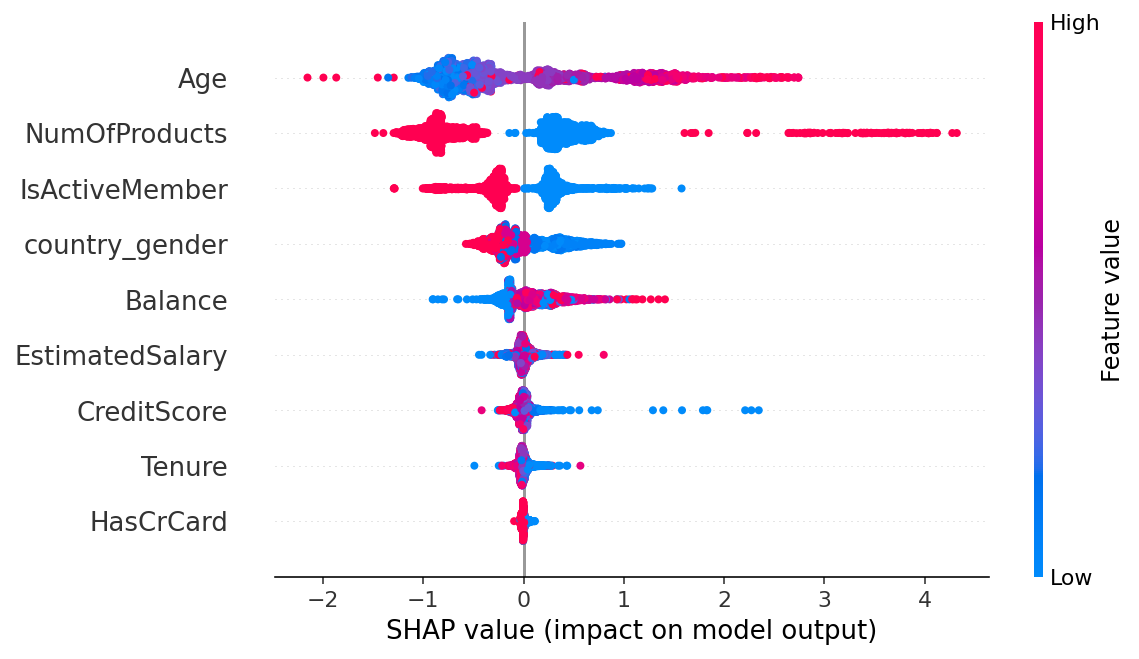

In [202]:
shap.summary_plot(shap_values, X_test)